**In this project, a simple communication system consisting of the transmitter, the channel (in this case AWGN), and a receiver is represented as an end-to-end autoencoder which is trained using deep learning and the input is one-hot encoded.** 

**Importing libraries**

In [ ]:

import numpy as np
import tensorflow as tf
#import tensorflow.compat.v1 as tf

import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from keras import backend as K
from numpy.random import rand, randn, seed
from scipy.special import erfc

import sys


In [ ]:
# for reproducing reslut
#from numpy.random import seed
#seed(3)
#tf.random.set_seed(3)

In [ ]:
#np.set_printoptions(precision=None, threshold=sys.maxsize, edgeitems=None, linewidth=None, suppress=None, nanstr=None, infstr=None, formatter=None, sign=None, floatmode=None,  legacy=None)


**Defining the autoencoder parameters**

In [ ]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16 
M = 256
k = np.log2(M)
k = int(k)
n_channel = 8
R = k/n_channel
print ('M:',M,'k:',k,'n:',n_channel)

M: 256 k: 8 n: 8


In [ ]:
#generating data of size N
N = 200000
#label = tf.random.uniform(shape=[N],minval=0,maxval=M,dtype=tf.int32) 

label = np.random.randint(M,size=N)
#data = tf.cast(label, dtype=tf.float32)
#print(data)

In [ ]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [ ]:
# checking data shape
data = np.array(data)
print (data.shape)

(200000, 256)


In [ ]:
#Generating random noise which is later introduced into the AWGN
B = np.random.normal(0, 1, n_channel)
b = np.random.normal(0, 1, n_channel)

In [ ]:
#Convert Eb/No in dB to noise standard deviation'''
def EbNo(EbNodB_):
  EbNo = 10**(EbNodB_/10)
  return EbNo

alpha = EbNo(7)
#alpha = np.sqrt(1/(2*R*alpha))
print(alpha)

5.011872336272722


**Defining the autoencoder with the additional noise introduced into the AWGN channel**

In [ ]:
# defining autoencoder and it's layer
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)

encoded2 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded1)
#encoded3 =  (np.random.normal(0, 1, n_channel) * encoded2) + (np.random.normal(0, 1, n_channel))
encoded3 =  ((B * encoded2) + b)
#encoded3 = Dense(n_channel, activation='tanh')(encoded2)
#encoded3 = Dense(n_channel, activation=keras.layers.LeakyReLU(alpha=0.01))(encoded2)
#encoded3 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded2)

#encoded3 = alpha*encoded3




EbNo_train = 5.01187 #  coverted 7 db of EbNo
encoded4 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded3)

decoded = Dense(M, activation='relu')(encoded4)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.005)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 8)                 2056      
                                                                 
 lambda_2 (Lambda)           (None, 8)                 0         
                                                                 
 tf.math.multiply_2 (TFOpLam  (None, 8)                0         
 bda)                                                            
                                                                 
 tf.__operators__.add_2 (TFO  (None, 8)                0         
 pLambda)                                                  

In [ ]:
# for tensor board visualization
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [ ]:
# traning auto encoder
autoencoder.fit(data, data,
                epochs=30,
                batch_size=100)

Epoch 1/30
2000/2000 [==============================] - 13s 6ms/step - loss: 0.7884
Epoch 2/30
2000/2000 [==============================] - 13s 7ms/step - loss: 0.4438
Epoch 3/30
2000/2000 [==============================] - 13s 6ms/step - loss: 0.3998
Epoch 4/30
2000/2000 [==============================] - 12s 6ms/step - loss: 0.3700
Epoch 5/30
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3498
Epoch 6/30
2000/2000 [==============================] - 12s 6ms/step - loss: 0.3339
Epoch 7/30
2000/2000 [==============================] - 12s 6ms/step - loss: 0.3249
Epoch 8/30
2000/2000 [==============================] - 12s 6ms/step - loss: 0.3141
Epoch 9/30
2000/2000 [==============================] - 16s 8ms/step - loss: 0.3079
Epoch 10/30
2000/2000 [==============================] - 12s 6ms/step - loss: 0.3071
Epoch 11/30
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2993
Epoch 12/30
2000/2000 [==============================] - 12s 6ms/step - lo

In [ ]:
adam = Adam(learning_rate=0.0008)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

In [ ]:
autoencoder.fit(data, data, epochs=20,  batch_size=100)

Epoch 1/20
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2173
Epoch 2/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2134
Epoch 3/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2152
Epoch 4/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2106
Epoch 5/20
2000/2000 [==============================] - 13s 7ms/step - loss: 0.2093
Epoch 6/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2111
Epoch 7/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2098
Epoch 8/20
2000/2000 [==============================] - 13s 7ms/step - loss: 0.2112
Epoch 9/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2106
Epoch 10/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2101
Epoch 11/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2103
Epoch 12/20
2000/2000 [==============================] - 13s 7ms/step - lo

In [ ]:
# saving keras model
from keras.models import load_model
# if you want to save model then remove below comment
autoencoder.save('autoencoder_v_best.model')

In [ ]:
# making encoder from full autoencoder
encoder0 = Model(input_signal, encoded1)

In [ ]:
encoder1 =Model(input_signal, encoded2)

In [ ]:
# making encoder from full autoencoder
encoder = Model(input_signal, encoded3)


In [ ]:
print("Here is what I learned: {}".format(encoder1.get_weights()))

Here is what I learned: [array([[-1.51339424e+00,  1.04041421e+00,  4.85096604e-01,
         1.49558973e+00, -1.13213468e+00,  1.18388331e+00,
        -3.87605429e-01, -4.69751298e-01,  1.44136167e+00,
         4.81111765e-01, -1.15465307e+00,  7.43446946e-02,
        -1.88138112e-01,  9.63491023e-01, -2.58545399e-01,
        -1.05975437e+00,  4.19604242e-01,  6.30314529e-01,
         7.74477124e-02,  2.54639030e+00, -1.30775058e+00,
         1.04243481e+00, -1.46683109e+00,  4.15527201e+00,
        -1.59807950e-01, -1.26452935e+00, -6.93881661e-02,
        -4.91538852e-01,  5.31776667e+00, -5.62286615e-01,
        -1.54220378e+00, -1.21946764e+00, -6.84818447e-01,
        -5.19472539e-01, -8.99295807e-01,  6.31013513e-01,
         1.89648092e-01,  3.14786792e+00,  4.30604887e+00,
        -6.00133896e-01,  1.18479180e+00,  1.08588898e+00,
         5.24321198e-01, -1.89747706e-01, -6.78308383e-02,
         3.86666387e-01, -5.77959478e-01, -9.51748371e-01,
        -1.54383075e+00, -1.091

In [ ]:
# making decoder from full autoencoder
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)

deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [ ]:
# generating data for checking BER
# if you're not using t-sne for visulation than set N to 70,000 for better result 
# for t-sne use less N like N = 1500
N = 400000
test_label = np.random.randint(M,size=N)
test_label = np.array(test_label)
test_bin = ((test_label.reshape(-1,1) & (2**np.arange(k))) != 0).astype(int)
test_bin = test_bin[:,::-1]

test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)
#print(test_bin)
#print(test_data)

In [ ]:
# checking generated data
temp_test = 2
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])

1.0 100


In [ ]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [ ]:
#z = np.random.uniform(size=[5,8],low=-2,high=2)
v = 0.01333333 #1/12
b_std = v**(1/2)
z = 2 * (rand(N,k) >= 0.5) - 1
z = z * b_std
#print(z)


In [ ]:
N2 = 256
test_l = range(0,256)
#test_l = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63]

#test_l = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119]
#test_l = [120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239]
#test_l=[240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255]
test_s = []

for i in test_l:
    temp = np.zeros(M)
    temp[i] = 1
    test_s.append(temp)
    
test_s = np.array(test_s)


EbNodB_ = 7 #list(frange(-2,10,0.5))
ber = [None]*(EbNodB_)
EbNo=10.0**(EbNodB_/10.0)
noise_std = np.sqrt(1/(2*R*EbNo))
noise_mean = 0
no_errors = 0
nn = N2
noise = noise_std * np.random.randn(nn,n_channel)
encoder_output = encoder0.predict(test_s) 
non_linear_output = encoder1.predict(test_s) 
norm = encoder.predict(test_s)
#print(test_l)
#print(encoder_output)
#print(non_linear_output)
#print(norm)


8/8 [==============================] - 0s 3ms/step


In [ ]:
# calculating BER
# this is optimized BER function so it can handle large number of N
##z = np.random.uniform(size=[50000,8],low=-2,high=2)
EbNodB_range = list(frange(-2,11,1))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data) 
    #encoded11 =  ((B * encoded_signal) + b)
    #encoded22 = encoded3(encoded11)

    
    final_signal = encoded_signal + noise #+ z

    #final_signal = encoded_signal + noise #+ z
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    pred_output = np.array(pred_output)
    pred_s = ((pred_output.reshape(-1,1) & (2**np.arange(k))) != 0).astype(int)
    pred_s = pred_s[:,::-1]
    #no_errors = np.mean(pred_s != test_bin)
    no_errors = tf.reduce_mean(tf.cast(tf.not_equal(tf.cast(pred_s, tf.float32), test_bin),tf.float32))
    #print(no_errors)
    ber[n] = no_errors #/nn
   # print ('SNR:',EbNodB_range[n],'BER:',ber[n])
    # use below line for generating matlab like matrix which can be copy and paste for plotting ber graph in matlab
    #print(ber[n], " ",end='')
    print(tf.keras.backend.get_value(ber[n]), " ",end='')
    #print (pred_s)
    #print(no_errors)

12500/12500 [==============================] - 21s 2ms/step
0.001345  

In [ ]:
  theoryBER = np.zeros(len(EbNodB_range),float)
  for i in range(len(EbNodB_range)):
    theoryBER[i] = 0.5*erfc(np.sqrt(10**(EbNodB_range[i]/10)))


(-2.0, 12.0, 1e-05, 1.0)

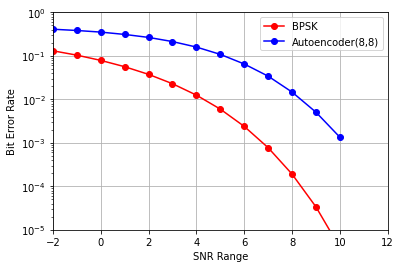

In [ ]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, theoryBER, '-ro',label='BPSK')

plt.plot(EbNodB_range, ber, '-bo',label='Autoencoder(8,8)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Bit Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
plt.axis([-2, 12, 1e-5, 1])


In [ ]:
# for saving figure remove below comment
#plt.savefig('AutoEncoder_2_2_constrained_BER_matplotlib')
plt.show()